In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg
from scipy.stats import levene

### First, we will define the necessary functions from [`project4_simulation_wirjadisastra_kenneth.ipynb`](project4_simulation_wirjadisastra_kenneth.ipynb).

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class WeatherRNN(nn.Module):
  def __init__(self, input_size:int, hidden_size:int, output_size:int, num_layers:int=1, rnn_type:str='RNN', dropout:float=0.0):
    super().__init__()

    # potential RNN classes
    rnn_options = {"RNN": nn.RNN,
                   "LSTM": nn.LSTM,
                   "GRU": nn.GRU}

    if rnn_type not in rnn_options:
      raise ValueError(f'rnn_type must be one of {list(rnn_options.keys())}')

    # force dropout to be 0 if num_layers == 1
    dropout = dropout if num_layers > 1 else 0.0

    self.rnn_type = rnn_type

    # define the rnn
    self.rnn = rnn_options[rnn_type](input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

    # fully connected linear layers
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, h0=None):
    batch_size = x.size(0)
    out, _ = self.rnn(x) if h0 is None else self.rnn(x, h0)
    out = self.fc(out[:,-1,:])
    return out, _
  

class TimeSeries(Dataset):
  def __init__(self, data, seq_len):
    self.data = torch.tensor(data, dtype=torch.float32)
    self.seq_len = seq_len

  def __len__(self):
    # subtract self.seq_len to account for data where previous sequence is unknown
    return len(self.data) - self.seq_len

  def __getitem__(self, start_idx):
    end_idx = start_idx + self.seq_len

    # generate the sequence of size seq_len and the target that follows directly after
    X_seq = self.data[start_idx:end_idx].unsqueeze(-1) # (seq_len x 1)
    y = self.data[end_idx].unsqueeze(-1) # (1,)

    return X_seq, y

In [4]:
def read_weather_data(path, col="TMAX"):
    # read data and format DATE column
    df = pd.read_csv(path)
    df["DATE"] = pd.to_datetime(df["DATE"])
    df.set_index("DATE", inplace=True)
    return pd.DataFrame(df[col])

def normalize(df, col, transformation):
    norm = transformation(df[col].values.reshape(-1,1))
    return norm

def to_dataset(data_norm, seq_len):
    dataset = TimeSeries(data_norm.values, seq_len=seq_len)
    return dataset

def to_loader(dataset, batch_size=32, shuffle=False, drop_last=True):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return dataloader

In [5]:
def test_RNN(model, dataloader, seq_len, device=device):
    # returns normalized predictions
    
    # store predictions in an array
    predictions = np.empty([len(dataloader)+seq_len, 1])

    # first seq_len entries not available
    predictions[:seq_len] = np.nan

    model.eval()

    with torch.no_grad():
        idx = seq_len # indices [0:seq_len] do not have associated output values
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            
            # make prediction
            out, _ = model(x)

            # add prediction to array
            predictions[idx] = out.item()
            idx += 1

    return predictions

### Now we prepare the test data to evaluate our model.

In [6]:
test_data_path = "../Project1/test_data/APA_weather_test.csv"

# read the test dataset
df_test = read_weather_data(test_data_path)

scaler = MinMaxScaler()

# normalize the test dataset and store in another pd.Series
test_norm = pd.Series(normalize(df_test, "TMAX", transformation=scaler.fit_transform).squeeze(axis=1),
                    index=df_test.index,
                    name="Norm")

# remove unnecessary columns in df_test, rename "TMAX" to "True"
df_test = pd.DataFrame(df_test["TMAX"])
df_test.rename(columns={"TMAX": "True"}, inplace=True)

# print true and weather normalized data
pd.concat([df_test, test_norm], axis=1)

,True,Norm
DATE,,
2022-03-21,45.0,0.470588
2022-03-22,40.0,0.421569
2022-03-23,52.0,0.539216
2022-03-24,64.0,0.656863
2022-03-25,63.0,0.647059
...,...,...
2025-03-30,52.0,0.539216
2025-03-31,61.0,0.627451
2025-04-01,51.0,0.529412


In [ ]:
seq_len=7
test_dataset = to_dataset(test_norm, seq_len=seq_len)
test_loader = to_loader(test_dataset,batch_size=1)

### Next we can load the models from [`project4_simulation_wirjadisastra_kenneth.ipynb`](project4_simulation_wirjadisastra_kenneth.ipynb) and make predictions based on the test data.

In [7]:
imputation_methods = ['KS', 'RM', 'LI']
percentages = [10, 25, 40]
ensemble_size = 15
prediction_cols = {}
for method in imputation_methods:
    for p in percentages:
        for n in range(ensemble_size):
            path = f'{method}_{p}_model/model{n+1}.pt'

            model = WeatherRNN(input_size=1,
                               hidden_size=16,
                               output_size=1,
                               num_layers=1,
                               rnn_type='LSTM')
            model.load_state_dict(torch.load(path, weights_only=True))

            test_predictions = scaler.inverse_transform(test_RNN(model, test_loader, seq_len=seq_len)).squeeze(axis=1)
            # insert predictions into prediction_cols
            prediction_cols[f'{method}_{p}_{n+1}'] = test_predictions

# create dataframe for predictions
prediction_df = pd.DataFrame(prediction_cols, index=df_test.index)

# add columns to df_test
df_test = pd.concat([df_test, prediction_df], axis=1)

# remove initial values (which all have no prediction)            
df_test = df_test.iloc[seq_len:]
df_test.head()

,True,KS_10_1,KS_10_2,KS_10_3,KS_10_4,KS_10_5,KS_10_6,KS_10_7,KS_10_8,KS_10_9,...,LI_40_6,LI_40_7,LI_40_8,LI_40_9,LI_40_10,LI_40_11,LI_40_12,LI_40_13,LI_40_14,LI_40_15
DATE,,,,,,,,,,,,,,,,,,,,,
2022-03-28,75.0,68.703417,68.909317,68.691373,68.929502,68.738381,68.452363,68.774817,68.799123,68.290352,...,70.064942,70.226570,69.230446,69.723361,69.611319,70.200446,69.650065,69.367700,69.800093,69.208839
2022-03-29,54.0,71.167989,71.184088,70.992432,71.321756,71.005929,70.879703,70.996634,71.115041,70.682874,...,72.094617,72.258786,71.166791,71.703462,71.806859,72.059385,71.493483,71.525602,71.800987,71.184532
2022-03-30,45.0,57.636441,57.364108,57.337747,57.849078,57.304691,56.999577,57.318200,57.390567,56.820683,...,56.388016,56.710032,55.487258,55.724900,55.935932,56.039061,55.190382,55.632137,56.020938,55.655318
2022-03-31,60.0,53.859413,53.240430,52.995042,53.673193,53.030018,53.055407,52.991595,53.319484,52.767425,...,51.054009,51.562725,49.882401,50.106564,50.872409,50.397525,49.524132,50.518857,50.575666,50.242390
2022-04-01,56.0,63.958341,63.704265,63.122252,63.740719,63.355304,63.076150,63.389460,63.668608,62.874372,...,62.515993,63.154323,61.057467,61.379301,61.896456,62.318313,61.366552,61.619071,61.995798,61.405012


### Now that we have the predictions, let's calculate the RMSE statistics.

In [8]:
# store all RMSE and biases in 3d numpy arrays to compute the mean and std

RMSE = np.zeros([len(imputation_methods),
                 len(percentages),
                 ensemble_size])

# initialize empty dataframe to store results of experiment
df_results =pd.DataFrame({'Method': [],
                          'p': [],
                          'RMSE': []})

num_p = len(percentages)

row_counter = 0

for m, method in enumerate(imputation_methods):
    for p_idx, p in enumerate(percentages):
        for n in range(ensemble_size):
            col = f'{method}_' + f'{p}'[-2:] + f'_{n+1}'

            # compute RMSE and signed bias
            RMSE[m, p_idx, n] = root_mean_squared_error(df_test['True'], df_test[col])

            
            #df_idx = n + p_idx*ensemble_size + m*ensemble_size*num_p
            # add results to the dataframe and increment row counter
            df_results.loc[row_counter] = [method, p, RMSE[m,p_idx,n]]
            row_counter += 1

df_results

,Method,p,RMSE
0,KS,10,9.334622
1,KS,10,9.317046
2,KS,10,9.310286
3,KS,10,9.331336
4,KS,10,9.308061
...,...,...,...
130,LI,40,9.349606
131,LI,40,9.374562
132,LI,40,9.354898
133,LI,40,9.339137


### The next step is to perform an analysis of the statistics. We can use analysis of variance (ANOVA), but we must first check for normality of the residuals and homoscedacisity.

### We will construct a Q-Q plot to check for normality in the residuals

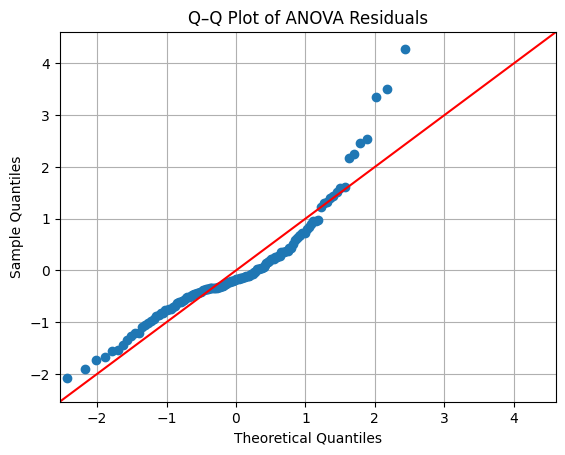

In [11]:
model = ols('RMSE ~ C(Method) + C(p) + C(Method):C(p)', data=df_results).fit()
residuals = model.resid
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q–Q Plot of ANOVA Residuals")
plt.grid(True)
plt.show()

### The residuals appear to be somewhat normally distributed. However, the right tail does not seem to follow a normal distribution.

### Next we will check for homoscedacisity using a residual vs fitted plot.

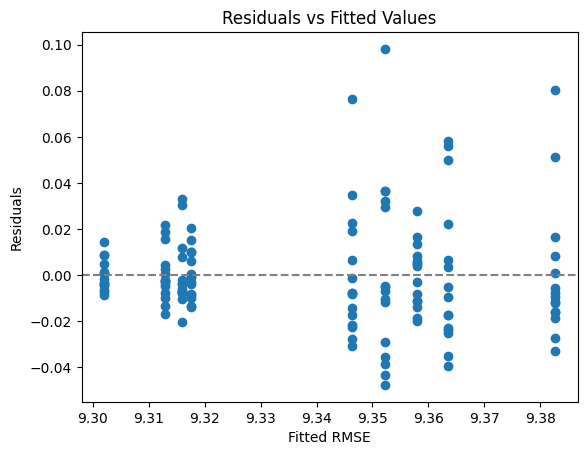

In [12]:
fitted_vals = model.fittedvalues

plt.scatter(fitted_vals, residuals)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Fitted RMSE")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

### There does not appear to be equal variance across the groups. We can confirm this by conductin Levene's test with $\alpha=0.05$.

In [14]:
# Groups split by Method and p
groups = [group['RMSE'].values for name, group in df_results.groupby(['Method', 'p'])]

stat, p_value = levene(*groups)
print(f"Levene’s test p-value: {p_value:.3f}")

Levene’s test p-value: 0.001


### Levene's test confirms that we do not have hederoscedacisity. Therefore we cannot perform two way ANOVA on our data. Instead we will perform one way Welch's ANOVA for unequal variance on the imputation method.

In [37]:
p_levels = df_results['p'].unique()

for level in p_levels:
    subset = df_results[df_results['p'] == level]
    print(f"Welch's ANOVA for Method at p = {level}")
    welch_res = pg.welch_anova(dv='RMSE', between='Method', data=subset)
    print(welch_res, '\n')

Welch's ANOVA for Method at p = 10
   Source  ddof1      ddof2          F     p-unc       np2
0  Method      2  26.347203  13.417498  0.000096  0.327606 

Welch's ANOVA for Method at p = 25
   Source  ddof1      ddof2          F     p-unc       np2
0  Method      2  24.080086  10.253601  0.000601  0.237301 

Welch's ANOVA for Method at p = 40
   Source  ddof1      ddof2         F     p-unc       np2
0  Method      2  23.982019  4.089646  0.029633  0.143508 



### For $\alpha=0.05$, we find that the imputation method does have a significant influence on the RMSE. However, this test only tells us the at least one of the imputation methods is significantly different from the others. It does not tell us which ones are different. We must perform post-hoc tests to determine this.

### 

In [23]:
GH_results = {}
for p in percentages:
    df_p = df_results[df_results['p'] == p]

    GH_results[p] = pg.pairwise_gameshowell(dv='RMSE', between='Method', data=df_p)

In [24]:
GH_results[10]

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,KS,LI,9.312834,9.301996,0.010837,0.003376,3.210459,22.732310,0.010523,1.140610
1,KS,RM,9.312834,9.317541,-0.004708,0.003959,-1.189035,27.835945,0.469433,-0.422440
2,LI,RM,9.301996,9.317541,-0.015545,0.003192,-4.869435,23.799105,0.000169,-1.730011


In [25]:
GH_results[25]

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,KS,LI,9.352290,9.315897,0.036393,0.010995,3.309829,17.785196,0.010471,1.175914
1,KS,RM,9.352290,9.346314,0.005977,0.012659,0.472120,25.306858,0.884940,0.167735
2,LI,RM,9.315897,9.346314,-0.030416,0.008284,-3.671744,21.071976,0.003873,-1.304495


In [26]:
GH_results[40]

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,KS,LI,9.363477,9.357964,0.005513,0.009123,0.604241,18.872084,0.819539,0.214674
1,KS,RM,9.363477,9.382658,-0.019181,0.011427,-1.678579,27.818687,0.231097,-0.596365
2,LI,RM,9.357964,9.382658,-0.024694,0.008526,-2.896321,19.660235,0.023470,-1.029004


### For p=10% and p=25%, LI has the lowest mean RMSE. For p=40%, KS has the lowest mean RMSE, but LI does not have a significantly different mean.